# Winning Jeopardy

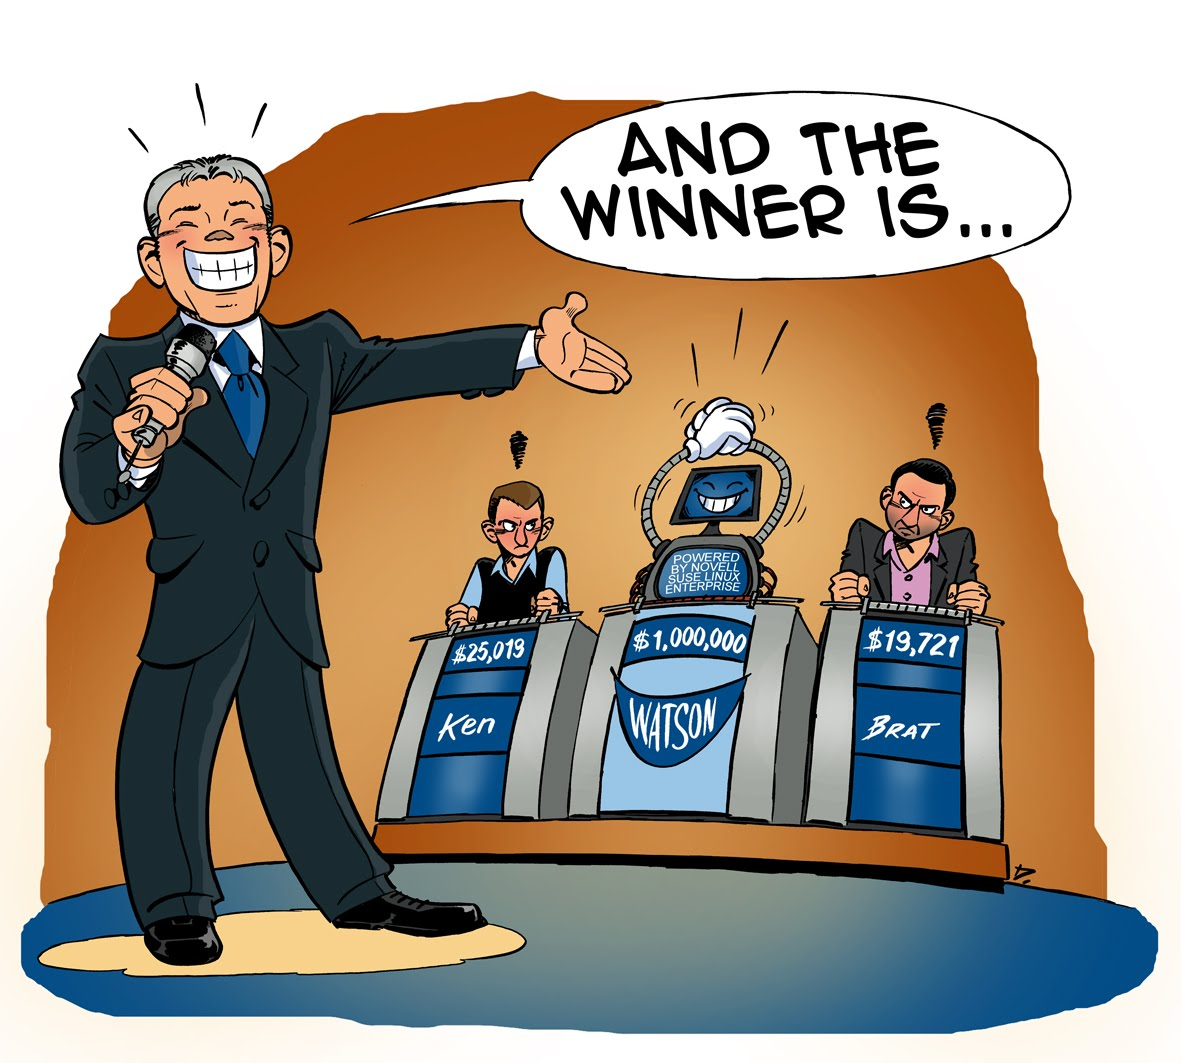





<a href="https://www.jeopardy.com/" target="_blank">**Jeopardy**</a> is a popular TV show in the USA where participants answer questions to win money. It's been running for many years, and it become a part the  major force in popular culture. 

The aim of this project -  find strategy  to win in future game  based  on the  dataset of Jeopardy questions to figure out some patterns in the questions in the past time .

The dataset is named JEOPARDY_CSV.csv, short description this dataset you can see <a href="https://www.reddit.com/r/datasets/comments/1uyd0t/200000_jeopardy_questions_in_a_json_file/" target="_blank">here</a>.

JEOPARDY_CSV.csv contains 216,930 rows ans 7 columns from the beginning of a full dataset of Jeopardy questions shows  from 10 September 1984 to 27 January 2012, which you can download <a href="https://drive.google.com/file/d/0BwT5wj_P7BKXUl9tOUJWYzVvUjA/view?usp=sharing" target="_blank">here</a>.


## 1. Import and open Jeopardy dataset

Import all required modules, open dataset and get general information about it.

In [1]:
from IPython.display import display
import gensim
from gensim.parsing.preprocessing import STOPWORDS
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
from scipy.stats import chisquare
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from stop_words import get_stop_words
import warnings
warnings.filterwarnings('ignore')  # to suppress gensim-levenshtein version conflict

jeopardy = pd.read_csv('data/JEOPARDY_CSV.csv')
jeopardy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216930 entries, 0 to 216929
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Show Number  216930 non-null  int64 
 1    Air Date    216930 non-null  object
 2    Round       216930 non-null  object
 3    Category    216930 non-null  object
 4    Value       216930 non-null  object
 5    Question    216930 non-null  object
 6    Answer      216928 non-null  object
dtypes: int64(1), object(6)
memory usage: 11.6+ MB


Print  name of columns:

In [2]:
jeopardy.columns

Index(['Show Number', ' Air Date', ' Round', ' Category', ' Value',
       ' Question', ' Answer'],
      dtype='object')

and rename columns to standard form (remove white spaces and replace white spaces between words to low line symbol) and check its:

In [3]:
new_names = []

for column in jeopardy.columns:
    new_names.append(re.sub(r"(\b\s+\b)","_", column.lstrip().lower()))

jeopardy.columns = new_names
jeopardy.columns

Index(['show_number', 'air_date', 'round', 'category', 'value', 'question',
       'answer'],
      dtype='object')

As see above, row  `answer` contain the  NaN values, look these rows and remove its :

In [4]:
display(jeopardy[jeopardy.isna().any(axis=1)])
jeopardy.reset_index()
jeopardy.info()

,show_number,air_date,round,category,value,question,answer
94817,4346,2003-06-23,Jeopardy!,"GOING ""N""SANE",$200,"It often precedes ""and void""",NaN
143297,6177,2011-06-21,Double Jeopardy!,NOTHING,$400,"This word for ""nothing"" precedes ""and void"" to...",NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216930 entries, 0 to 216929
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   show_number  216930 non-null  int64 
 1   air_date     216930 non-null  object
 2   round        216930 non-null  object
 3   category     216930 non-null  object
 4   value        216930 non-null  object
 5   question     216930 non-null  object
 6   answer       216928 non-null  object
dtypes: int64(1), object(6)
memory usage: 11.6+ MB


and rebuild index

In [5]:
# drop NaN values
jeopardy.dropna(axis = 0, inplace = True)
# reset index
jeopardy.reset_index(drop = True, inplace=True)

## 2. Normalizing data in columns 

Add two new columns - `clean_question` and `clean_answer` for normalized text and fill its. 

In [6]:
# list of text and new columns
text_column = ['question', 'answer']
clean_column = ["clean_question", "clean_answer"]

#insert new columns with normalized text
for i, column in  enumerate (clean_column):
    jeopardy.insert(len(jeopardy.columns), column, 
                    jeopardy[text_column[i]].str.replace(r"([^A-Za-z0-9])"," " ).\
                        str.replace(r"(\s+)", " ").str.lower().str.lstrip())

Convert string values in `value` row to integer. Turn on `errors = "coerce"` options for converting clear text values without any numbers symbols to NaN and check conversion result - I see below that 3,634 rows in column `value` haven't digital values after conversion  and remove contains NaN values rows:

In [7]:
# convert string to integer in the `value` column
jeopardy.value = pd.to_numeric(jeopardy.value.str.replace(r"(\D)",""),
                               errors = "coerce", 
                               downcast = "integer")

# Check and view rows with NaN values
display(jeopardy[jeopardy.isna().any(axis=1)])

,show_number,air_date,round,category,value,question,answer,clean_question,clean_answer
55,4680,2004-12-31,Final Jeopardy!,THE SOLAR SYSTEM,NaN,Objects that pass closer to the sun than Mercu...,Icarus,objects that pass closer to the sun than mercu...,icarus
116,5957,2010-07-06,Final Jeopardy!,HISTORIC WOMEN,NaN,She was born in Virginia around 1596 & died in...,Pocahontas,she was born in virginia around 1596 died in k...,pocahontas
174,3751,2000-12-18,Final Jeopardy!,SPORTS LEGENDS,NaN,If Joe DiMaggio's hitting streak had gone one ...,H.J. Heinz (Heinz 57 Varieties),if joe dimaggio s hitting streak had gone one ...,h j heinz heinz 57 varieties
235,3673,2000-07-19,Final Jeopardy!,THE MAP OF EUROPE,NaN,"Bordering Italy, Austria, Hungary & Croatia, i...",Slovenia,bordering italy austria hungary croatia it s o...,slovenia
296,4931,2006-02-06,Final Jeopardy!,FAMOUS SHIPS,NaN,"On December 27, 1831 it departed Plymouth, Eng...",the HMS Beagle,on december 27 1831 it departed plymouth engla...,the hms beagle
...,...,...,...,...,...,...,...,...,...
216684,3940,2001-10-19,Final Jeopardy!,MAJOR LEAGUE BASEBALL TEAM NAMES,NaN,This team received its name after an 1890 inci...,Pittsburgh Pirates,this team received its name after an 1890 inci...,pittsburgh pirates
216744,6044,2010-12-16,Final Jeopardy!,SKYSCRAPERS,NaN,After a construction boom fueled by oil & gas ...,Moscow,after a construction boom fueled by oil gas mo...,moscow
216805,5070,2006-09-29,Final Jeopardy!,NATIONAL CAPITALS,NaN,"This city's website calls it ""the last divided...",Nicosia,this city s website calls it the last divided ...,nicosia
216866,5195,2007-03-23,Final Jeopardy!,BESTSELLING AUTHORS,NaN,He had the year's bestselling novel a record 7...,John Grisham,he had the year s bestselling novel a record 7...,john grisham


In [8]:
# remove NaN values rows
jeopardy.dropna(axis = 0, inplace = True)

# reset index
jeopardy.reset_index(drop = True,inplace = True)

# convert float to integer 
jeopardy.value  = jeopardy.value.astype(int)

# convert string to datatime in the `air_date` column
jeopardy.air_date = pd.to_datetime(jeopardy.air_date)

# view cleaned and transformed dataset 
jeopardy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213294 entries, 0 to 213293
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   show_number     213294 non-null  int64         
 1   air_date        213294 non-null  datetime64[ns]
 2   round           213294 non-null  object        
 3   category        213294 non-null  object        
 4   value           213294 non-null  int64         
 5   question        213294 non-null  object        
 6   answer          213294 non-null  object        
 7   clean_question  213294 non-null  object        
 8   clean_answer    213294 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 14.6+ MB


##  3. Naive answers in the questions

Write function `naive_answer_in_quest_count` and creating new column "naive_answer_in_question" ` 

In [9]:
def naive_answer_in_quest_count(row):
    answer = row.clean_answer.split()
    question = row.clean_question.split()
    if "the" in answer:
        answer.remove("the")
    if len(answer) == 0:
        return 0
    matches = 0
    for item in answer:
        if item in question:
            matches += 1
    return float(matches/len(answer))


# insert new column 
jeopardy["naive_answer_in_question"] = jeopardy.apply(naive_answer_in_quest_count, axis = 1)

# Calculate and print naive mean answer in question
naive_answer_in_question_mean = jeopardy.naive_answer_in_question.mean()
print(f"Naive  mean for answers in questions = {naive_answer_in_question_mean:.3%}")

Naive  mean for answers in questions = 6.177%


# 4. Naive recycled questions

In [10]:
naive_question_overlap = []
naive_terms_used = set()

jeopardy = jeopardy.sort_values("air_date")

for i, row in jeopardy.iterrows():
        question = row.clean_question.split()
        question = [word for word in question if len(word) > 5]
        matches = 0
        for word in question:
            if word in naive_terms_used:
                matches += 1
            else:
                naive_terms_used.add(word)
        if len(question) > 0:
            matches  = float(matches/len(question))
        naive_question_overlap.append(matches)

jeopardy["naive_question_overlap"] = naive_question_overlap
naive_recycled_question_mean = jeopardy.naive_question_overlap.mean()
print(f"Naive  mean for recycled questions = {naive_recycled_question_mean:.3%}")

Naive  mean for recycled questions = 89.939%


I see here the significant overlap between meaningful words of all the questions of our dataset. I looking here **whole 100% of questions of the full Jeopardy dataset** with **213,294 rows** and I assume that some question recycling is quite possible and must have  investigated in more detail in the next parts.

## 5. General word statistics for clean_question and clean_answer

Before go to further part collect general statistic about words in the columns `clean_question` and `clean_answer`:

In [11]:
# Get statistics words for clean_question 
clean_question_words = set()
clean_questions = list(jeopardy.clean_question.values)
for sentence in clean_questions:
    sentence = sentence.split()
    for word in sentence:
        if word not in clean_question_words:
            clean_question_words.add(word)

# Get statistics words for  clean_answers
clean_answer_words = set()
clean_answers = list(jeopardy.clean_answer.values)
for sentence in clean_answers:
    sentence = sentence.split()
    for word in sentence:
        if word not in clean_answer_words:
            clean_answer_words.add(word)
            
# Total unique words in clean_question and clean_answer 
clean_observed_words = clean_question_words | clean_answer_words
# Joint  unique words in clean_question and clean_answer
clean_intersect_words = clean_question_words & clean_answer_words

print(f"Unique words in clean_question = {len(list(clean_question_words)):,}")
print(f"Unique words in clean_answers = {len(list(clean_answer_words)):,}")
print(f"Total words in clean_queston and clean_answer = {len(list(clean_observed_words)):,}")
print(f"Joint words for clean_queston and clean_answer = {len(list(clean_intersect_words)):,}")

Unique words in clean_question = 86,684
Unique words in clean_answers = 36,486
Total words in clean_queston and clean_answer = 92,266
Joint words for clean_queston and clean_answer = 30,904


## 6. Deep check answers in the questions and deep recycled questions

Every language contains commonly used general words that do not carry any information value in answer and questions like articles `a`, `an`, `the` and etc. It is proposed to cut off these words using criteria length of word more than five symbols. I suppose that criteria is  uncertain and artificial and serious distorts the real map of the data. 

For getting real map of data I suppose remove parasite words (after their normalization) from its importing from Python ML library and recalculate values for answers in questions and recycled questions. Keep in the mind, that in the `Naive answers in the questions` didn't taken into account only one `the` article. Defining list of the parasite words.

In [12]:
# Creating  parasite_words set by union from different libraries  for futher
# deep cleaning answers and questions columns
parasite_words = set(get_stop_words('en')) | set(STOPWORDS) | set(ENGLISH_STOP_WORDS)

# create list and  printing all parasite words
parasite = list(parasite_words)
parasite.sort()
print(parasite)
print(f"Total parasite words - {len(parasite)}.")

['a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'amoungst', 'amount', 'an', 'and', 'another', 'any', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere', 'are', "aren't", 'around', 'as', 'at', 'back', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'below', 'beside', 'besides', 'between', 'beyond', 'bill', 'both', 'bottom', 'but', 'by', 'call', 'can', "can't", 'cannot', 'cant', 'co', 'computer', 'con', 'could', "couldn't", 'couldnt', 'cry', 'de', 'describe', 'detail', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'done', 'down', 'due', 'during', 'each', 'eg', 'eight', 'either', 'eleven', 'else', 'elsewhere', 'empty', 'enough', 'etc', 'even', 'ever', 'every', 'everyone', 'everything', 'everywhere', 'except', 'few', 'fifteen', 'fifty', 'fill', 'find', 'fire',

As see above instead one article `the` I must have remove 390 word from questions and answer columns.
May be I lose some styles Homer Simpson's questions: "Speak the first letter of the English alphabet?", but I think that answer for this questions doesn't require writing this notebook. 
Convert normalizing  parasite  words in the `parasite` list.

In [13]:
parasite_normal_words = []
# Remove apostrophes '
for word in parasite:
    item = re.sub(r"(')", " ",  word).split()
    for part  in item:
        if part not in parasite_normal_words:
            parasite_normal_words.append(part)
print(parasite_normal_words)
print(f"Total parasite normalized words - {len(parasite_normal_words)}.")

['a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'amoungst', 'amount', 'an', 'and', 'another', 'any', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere', 'are', 'aren', 't', 'around', 'as', 'at', 'back', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'below', 'beside', 'besides', 'between', 'beyond', 'bill', 'both', 'bottom', 'but', 'by', 'call', 'can', 'cannot', 'cant', 'co', 'computer', 'con', 'could', 'couldn', 'couldnt', 'cry', 'de', 'describe', 'detail', 'did', 'didn', 'do', 'does', 'doesn', 'doing', 'don', 'done', 'down', 'due', 'during', 'each', 'eg', 'eight', 'either', 'eleven', 'else', 'elsewhere', 'empty', 'enough', 'etc', 'even', 'ever', 'every', 'everyone', 'everything', 'everywhere', 'except', 'few', 'fifteen', 'fifty', 'fill', 'find', 'fire', 'first', 'five', 'for', 'former', 'fo

In [14]:
# Define function for creating deep_question and deep_answer

def deep_clean_question(row):
    sentence_in = row.clean_question.split()
    for word in sentence_in[:]:
        if word in parasite_normal_words:
            sentence_in.remove(word)
    if len(sentence_in) == 0:
        return np.nan
    else:
        sentence_out = ' '
        sentence_out = sentence_out.join(sentence_in)
        return sentence_out


def deep_clean_answer(row):
    sentence_in = row.clean_answer.split()
    for word in sentence_in[:]:
        if word in parasite_normal_words:
            sentence_in.remove(word)
    if len(sentence_in) == 0:
        return np.nan
    else:
        sentence_out = ' '
        sentence_out = sentence_out.join(sentence_in)
        return sentence_out

# Add new columns 
jeopardy["deep_question"] = jeopardy.apply(deep_clean_question, axis = 1)
jeopardy["deep_answer"] = jeopardy.apply(deep_clean_answer, axis = 1)

# reset index
jeopardy.reset_index(drop = True, inplace = True)

# Check and view rows with NaN values
display(jeopardy[jeopardy.isna().any(axis=1)])
jeopardy.info()

,show_number,air_date,round,category,value,question,answer,clean_question,clean_answer,naive_answer_in_question,naive_question_overlap,deep_question,deep_answer
15,1,1984-09-10,Double Jeopardy!,4-LETTER WORDS,1000,"It's the first 4-letter word in ""The Star Span...",what,it s the first 4 letter word in the star spang...,what,0.0,0.000000,4 letter word star spangled banner,NaN
54,2,1984-09-11,Jeopardy!,BY THE NUMBERS,500,Broadway hit that takes Fellini film a ½ step ...,Nine,broadway hit that takes fellini film a step fu...,nine,0.0,0.000000,broadway hit takes fellini film step,NaN
88,2,1984-09-11,Jeopardy!,BY THE NUMBERS,200,Three Dog Night called this the loneliest number,"""One""",three dog night called this the loneliest number,one,0.0,0.333333,dog night called loneliest number,NaN
145,3,1984-09-12,Jeopardy!,3-LETTER WORDS,200,Quixote or Drysdale,a Don,quixote or drysdale,a don,0.0,0.000000,quixote drysdale,NaN
221,5,1984-09-14,Jeopardy!,ALL NUMBERS,100,"It was ""enough"" for Dick van Patten",Eight,it was enough for dick van patten,eight,0.0,0.000000,dick van patten,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
213139,6296,2012-01-23,Jeopardy!,2-LETTER WORDS,600,"Supernatural elements appear in kiri, a play i...",no,supernatural elements appear in kiri a play in...,no,0.0,1.000000,supernatural elements appear kiri play japanes...,NaN
213272,6300,2012-01-27,Jeopardy!,THE TRUTH LIES THEREIN,600,"Old school CBS history show: ""You Are"" this",There,old school cbs history show you are this,there,0.0,1.000000,old school cbs history,NaN
213278,6300,2012-01-27,Jeopardy!,THE TRUTH LIES THEREIN,200,Symbol for the second-lightest element,He,symbol for the second lightest element,he,0.0,1.000000,symbol second lightest element,NaN
213292,6300,2012-01-27,Jeopardy!,STUPID ANSWERS,600,This was first imprinted in black on individua...,M,this was first imprinted in black on individua...,m,1.0,1.000000,imprinted black individual ms 1950,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213294 entries, 0 to 213293
Data columns (total 13 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   show_number               213294 non-null  int64         
 1   air_date                  213294 non-null  datetime64[ns]
 2   round                     213294 non-null  object        
 3   category                  213294 non-null  object        
 4   value                     213294 non-null  int64         
 5   question                  213294 non-null  object        
 6   answer                    213294 non-null  object        
 7   clean_question            213294 non-null  object        
 8   clean_answer              213294 non-null  object        
 9   naive_answer_in_question  213294 non-null  float64       
 10  naive_question_overlap    213294 non-null  float64       
 11  deep_question             213248 non-null  object        
 12  de

As see from cells  above  46 questions and  1,102 answers (0.490% from total rows of dataset) contained only parasite or trivial words. Remove its from dataset. 

In [15]:
# drop NaN values
jeopardy.dropna(axis = 0, inplace = True)

# reset index
jeopardy.reset_index(drop = True, inplace = True)

Recalculate ratio words from questions in the answers with modified function `deep_answer_in_quest_count`.

In [16]:
def deep_answer_in_quest_count(row):
    answer = row.deep_answer.split()
    question = row.deep_question.split()
    matches = 0
    for item in answer:
        if item in question:
            matches += 1
    return float(matches/len(answer))

jeopardy["deep_answer_in_question"] = jeopardy.apply(deep_answer_in_quest_count, axis = 1)
deep_answer_in_question_mean = jeopardy.deep_answer_in_question.mean()
print(f"Answers in the questions after remove parasite words =\
{deep_answer_in_question_mean:.3%}")

Answers in the questions after remove parasite words =4.065%


As see  from above cell, more roughly 1/3  part in `Naive  mean for answers in questions` contain parasite words. 
Recalculate  recycled words.

In [17]:
# sort by show air date
jeopardy = jeopardy.sort_values("air_date")

# reset index
jeopardy.reset_index(drop = True, inplace = True)

# Create empty list for words in questions
deep_question_overlap = []
deep_terms_used = set()

# Filling list and set above
for i, row in jeopardy.iterrows():
        question = row.deep_question.split()
        matches = 0
        for word in question:
            if word in deep_terms_used:
                matches += 1
            else:
                deep_terms_used.add(word)
        matches  = float(matches/len(question))
        deep_question_overlap.append(matches)

# Add  new column
jeopardy["deep_question_overlap"] = deep_question_overlap

# Recalculate mean value
deep_recycled_question_mean = jeopardy.naive_question_overlap.mean()
print(f"Deep  mean for recycled questions = {deep_recycled_question_mean:.3%}")

Deep  mean for recycled questions = 89.970%


As see from cell above parasite words  haven't practically affect to recycled questions ratio.
Collect word statistics.

In [18]:
# Statistics for deep words
deep_question_words = set()
deep_questions = list(jeopardy.deep_question.values)
for sentence in deep_questions:
    sentence = sentence.split()
    for word in sentence:
        if word not in deep_question_words:
            deep_question_words.add(word)

# Get statistics words for  deep_answers
deep_answer_words = set()
deep_answers = list(jeopardy.deep_answer.values)
for sentence in deep_answers:
    sentence = sentence.split()
    for word in sentence:
        if word not in deep_answer_words:
            deep_answer_words.add(word)
            
# Total unique words in deep_question and deep_answer 
deep_observed_words = deep_question_words | deep_answer_words
# Joint  unique words in deep_question and deep_answer
deep_intersect_words = deep_question_words & deep_answer_words

print(f"Unique words in deep_question = {len(list(deep_question_words)):,}")
print(f"Unique words in deep_answers = {len(list(deep_answer_words)):,}")
print(f"Total words in deep_queston and deep_answer = {len(list(deep_observed_words)):,}")
print(f"Joint words for deep_queston and deep_answer = {len(list(deep_intersect_words)):,}")

Unique words in deep_question = 86,174
Unique words in deep_answers = 36,186
Total words in deep_queston and deep_answer = 91,776
Joint words for deep_queston and deep_answer = 30,584


As see from cell above parasite words  haven't practically affect of word quantity in all categories.

## 7. Low value vs high value questions

There is almost 90 % overlap between terms in new questions and terms in old questions. This only looks at a small set of questions, and it doesn't look at phrases, it looks at single terms. This makes it relatively insignificant, but it does mean that it's worth looking more into the recycling of questions.
Divide  the questions into `jeopardy` by  two categories:

Low value -- Any row where Value is less or equal  800.

High value -- Any row where Value is greater than 800.

Add columns `high_value` and fill it:

In [19]:
# add column high_value and fill it
jeopardy["high_value"] = jeopardy.apply(lambda row: 1 if row.value > 800  else 0, axis = 1)
jeopardy.reset_index(drop = True, inplace = True)

create frequency dictionary, convert it to dataframe and output first most popular  25 words for columns  `high_count` and `low_count`.    

In [20]:
#define high low words dictionary

high_low_words = {}

# Flil friquency dictionary
for i, row in jeopardy.iterrows():
    question=row.deep_question.split()
    for word in question:
        if word not in high_low_words:
            if row.high_value == 1:
                high_low_words[word] = [1,0]
            else:
                high_low_words[word] = [0,1]
        else:
            if row.high_value == 1:
                high_low_words[word][0] += 1
            else:
                high_low_words[word][1] += 1

# Create dataframe
high_low_words_df = pd.DataFrame.from_dict(high_low_words, orient = "index")

# Drop index
high_low_words_df.reset_index(inplace = True)

# Rename default columns
high_low_words_df.columns = ['question_word', 'high_count', 'low_count'] 

# Output first most popular 25 words for high_count
high_low_words_df.sort_values("high_count", ascending = False, inplace = True)
high_low_words_df.head(25)

,question_word,high_count,low_count
57,j,7528,11881
59,com,5985,7105
60,media,5949,6997
56,www,5943,6986
58,archive,5932,6970
55,http,5932,6962
54,href,5931,6959
2980,target,4984,5663
1210,blank,4977,5639
7229,jpg,4940,5605


In [21]:
# Output first most popular 25 words for low_count
high_low_words_df.sort_values("low_count", ascending = False, inplace = True)
high_low_words_df.head(25)

,question_word,high_count,low_count
57,j,7528,11881
59,com,5985,7105
60,media,5949,6997
56,www,5943,6986
58,archive,5932,6970
55,http,5932,6962
54,href,5931,6959
2980,target,4984,5663
1210,blank,4977,5639
7229,jpg,4940,5605


As  see two cells above  the list of words in both cells is almost the same with little permutation.

## 8. Applying the Chi-squared Test

Calculate chi-squared values for all words in the dataframe `high_low_words_df` and view  30 most popular words.

In [22]:
high_value_general = jeopardy[jeopardy.high_value ==1].shape[0]
low_value_general = jeopardy[jeopardy.high_value ==0].shape[0]
total_general = jeopardy.shape[0]

# Calculate expectation values for high values
high_low_words_df['high_expect'] = 1.0  * high_value_general * \
                                    (high_low_words_df["high_count"] + 
                                    high_low_words_df["low_count"]) \
                                    / total_general   

# Calculate expectation values for high values
high_low_words_df['low_expect'] = 1.0  * low_value_general * \
                                    (high_low_words_df["high_count"] + 
                                    high_low_words_df["low_count"]) \
                                    / total_general   

# Add empty columns chisq_stat and p_val to high_low_words_df
high_low_words_df['chisq_stat'] = 0.0
high_low_words_df['p_val'] = 0.0


# Calculate statistics and p-value and fill empty columns

for i, row in high_low_words_df.iterrows():
    observed =np.array([row["high_count"], row["low_count"]])
    expected = np.array([row["high_expect"], row["low_expect"]])
    chisq_stat, p_val = chisquare(observed, expected)
    high_low_words_df.at[i, "chisq_stat"] =  chisq_stat
    high_low_words_df.at[i, "p_val"] = p_val
    
high_low_words_df.sort_values("low_count", ascending = False, inplace = True)
high_low_words_df.head(30)

,question_word,high_count,low_count,high_expect,low_expect,chisq_stat,p_val
57,j,7528,11881,5597.027570,13811.972430,936.142920,1.364439e-205
59,com,5985,7105,3774.799881,9315.200119,1818.514299,0.000000e+00
60,media,5949,6997,3733.274199,9212.725801,1847.947370,0.000000e+00
56,www,5943,6986,3728.371861,9200.628139,1848.544301,0.000000e+00
58,archive,5932,6970,3720.585796,9181.414204,1847.040095,0.000000e+00
55,http,5932,6962,3718.278813,9175.721187,1852.044205,0.000000e+00
54,href,5931,6959,3717.125322,9172.874678,1852.875844,0.000000e+00
2980,target,4984,5663,3070.305144,7576.694856,1676.143881,0.000000e+00
1210,blank,4977,5639,3061.365587,7554.634413,1684.447662,0.000000e+00
7229,jpg,4940,5605,3040.891119,7504.108881,1666.657329,0.000000e+00


As see in the cell above  values chi-squared statistics have great dispersion from near zero to thousands - that are  some  words have observed values  are close to expected values  and some words have  observed  values   are  far from expected values. 

In our case, degrees of freedom (df) = 1 and **α**  has next values for statistical signification

**0.05 - 3.84**

**0.025 - 5.02**

**0.01 - 6.63**

**0.005 - 7.88**

**0.001 - 10.83**

Roughly estimate word quantity with chi-square statistic near zero and **α**  less **0.05** and **0.001**:

In [23]:
print(f"Words with chi-square statistics value < 0.105 - observed values almost expected values")
# Chi-squared word than observed almost expected and probability over  74%
display(high_low_words_df[high_low_words_df.chisq_stat < 0.105].sort_values("chisq_stat",ascending =False))


print(f"Words with chi-square statistic value > 0.105 and < 3.84 - The 'Grey' zone")
# Chi-squared words than chi-square statistics over α = 0.05 and less 0.105 
display(high_low_words_df[(high_low_words_df.chisq_stat > .105) & (high_low_words_df.chisq_stat < 3.84)].sort_values("chisq_stat"))

print(f"Words with chi-square statistic value > 3.84 and < 10.83 - statistical signification level 1")
# Chi-squared words than chi-square statistics over α = 0.05 
display(high_low_words_df[(high_low_words_df.chisq_stat > 3.84) & (high_low_words_df.chisq_stat < 10.83)].sort_values("chisq_stat"))

print(f"Chi-square statistics value > 10.83 - statistical signification level 2")
# Chi-squared words than chi-square statistics over α = 0.05
display(high_low_words_df[high_low_words_df.chisq_stat > 10.83].sort_values("chisq_stat"))

Words with chi-square statistics value < 0.105 - observed values almost expected values


,question_word,high_count,low_count,high_expect,low_expect,chisq_stat,p_val
7876,approved,24,64,25.376806,62.623194,1.049678e-01,0.745948
5255,revealed,24,64,25.376806,62.623194,1.049678e-01,0.745948
7637,solomon,24,64,25.376806,62.623194,1.049678e-01,0.745948
3067,goes,170,432,173.600422,428.399578,1.049309e-01,0.745991
6243,buddy,33,87,34.604735,85.395265,1.045728e-01,0.746410
...,...,...,...,...,...,...,...
12454,sen,15,37,14.995385,37.004615,1.995599e-06,0.998873
404,ranger,15,37,14.995385,37.004615,1.995599e-06,0.998873
1916,68,15,37,14.995385,37.004615,1.995599e-06,0.998873
1506,cod,15,37,14.995385,37.004615,1.995599e-06,0.998873


Words with chi-square statistic value > 0.105 and < 3.84 - The 'Grey' zone


,question_word,high_count,low_count,high_expect,low_expect,chisq_stat,p_val
5089,hangs,17,46,18.167486,44.832514,0.105428,0.745411
403,lone,17,46,18.167486,44.832514,0.105428,0.745411
623,queens,17,46,18.167486,44.832514,0.105428,0.745411
8198,trust,17,46,18.167486,44.832514,0.105428,0.745411
809,best,404,978,398.531202,983.468798,0.105455,0.745379
...,...,...,...,...,...,...,...
2167,vote,75,140,62.000151,152.999849,3.830287,0.050334
457,selling,49,166,62.000151,152.999849,3.830465,0.050329
7507,escaped,31,49,23.069824,56.930176,3.830618,0.050324
14161,noodles,4,27,8.939557,22.060443,3.835371,0.050182


Words with chi-square statistic value > 3.84 and < 10.83 - statistical signification level 1


,question_word,high_count,low_count,high_expect,low_expect,chisq_stat,p_val
13448,pleasure,30,47,22.204705,54.795295,3.845630,0.049876
2925,function,30,47,22.204705,54.795295,3.845630,0.049876
847,bread,63,206,77.572282,191.427718,3.846768,0.049842
5203,impact,20,28,13.841894,34.158106,3.849872,0.049750
23065,finnish,20,28,13.841894,34.158106,3.849872,0.049750
...,...,...,...,...,...,...,...
2192,atomic,82,128,60.558287,149.441713,10.668242,0.001090
2458,irish,126,216,98.623496,243.376504,10.678815,0.001084
8938,peanuts,8,63,20.474468,50.525532,10.680189,0.001083
20076,ding,1,32,9.516302,23.483698,10.709800,0.001066


Chi-square statistics value > 10.83 - statistical signification level 2


,question_word,high_count,low_count,high_expect,low_expect,chisq_stat,p_val
8588,traveling,47,62,31.432635,77.567365,10.834202,0.000996
11592,chancellor,39,48,25.088433,61.911567,10.839918,0.000993
18633,overthrown,12,7,5.479083,13.520917,10.905784,0.000959
19315,panels,12,7,5.479083,13.520917,10.905784,0.000959
24011,feeds,21,19,11.534912,28.465088,10.913964,0.000954
...,...,...,...,...,...,...,...
60,media,5949,6997,3733.274199,9212.725801,1847.947370,0.000000
56,www,5943,6986,3728.371861,9200.628139,1848.544301,0.000000
55,http,5932,6962,3718.278813,9175.721187,1852.044205,0.000000
54,href,5931,6959,3717.125322,9172.874678,1852.875844,0.000000




As see above for word in high and low price categories of questions, <a href="https://support.minitab.com/en-us/minitab/18/help-and-how-to/statistics/tables/how-to/chi-square-test-for-association/interpret-the-results/key-results/" target="_blank">formally definition </a>   statistical signification for chi-squared test value > 3.84 (α = .05 for df = 1)   `is not enough evidence to conclude that the variables are associated` satisfy only 4,574 plus 542 = **5,116 words (5.937%)**.

`Grey zone (between 0.105 and 3.84)` contains **71,167 words (82.585%)**.

`Observed almost expectation words` contains **9,891 words (11.478%)**.

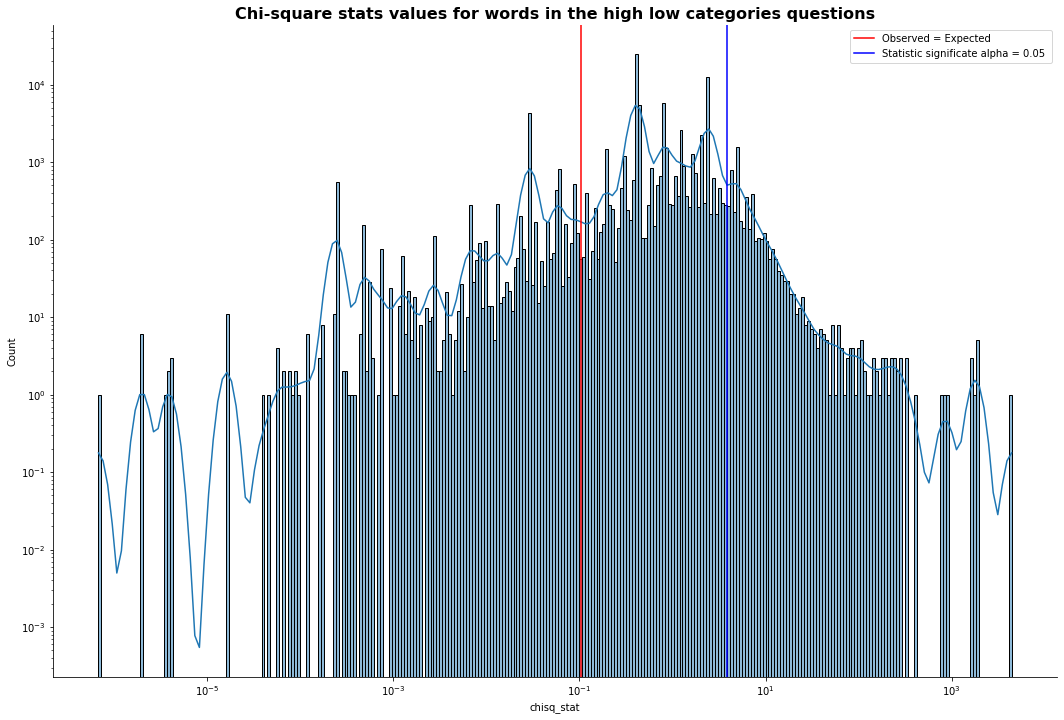

In [24]:
ax, fig = plt.subplots(figsize = (18,12))
ax = sns.histplot(data=high_low_words_df, x="chisq_stat", log_scale=True, kde = True)
ax.axvline(x = 0.105, color = 'red', label ="Observed = Expected")
ax.axvline(x = 3.84, color = 'blue', label ="Statistic significate alpha = 0.05 ")
ax.set_title("Chi-square stats values for words in the high low categories questions", fontsize = 16,
            weight = "bold")
# Set log10 scale for y
ax.set_yscale("log")

# Turn off top and right spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.legend()

plt.show()

Add new column `stat_cat` to high_low_words_df and plot pie chart for statistic signification categories:

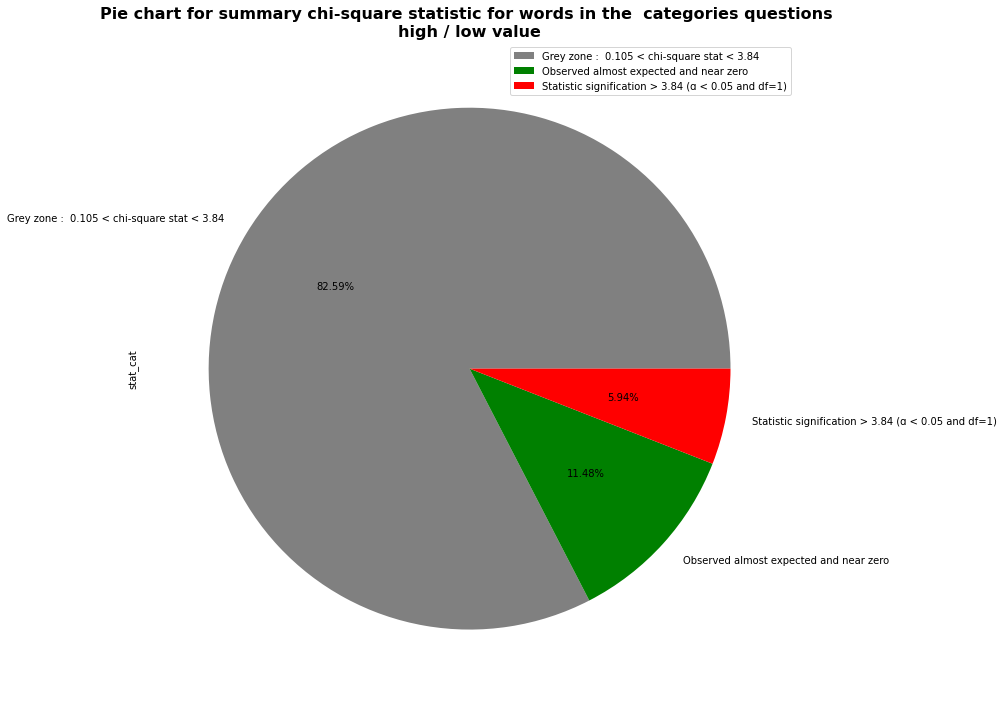

In [25]:
# Add new column `stat_cat` to high_low_words_df

high_low_words_df["stat_cat"] = high_low_words_df.apply(
    lambda row:"Observed almost expected and near zero" if row.chisq_stat < 0.105 
    else ("Grey zone :  0.105 < chi-square stat < 3.84" if row.chisq_stat <3.84 
    else "Statistic signification > 3.84 (ɑ < 0.05 and df=1)"), axis = 1)

ax, fig = plt.subplots(figsize = (18,12))
colors_pie = ("grey", "green","red") 
ax = high_low_words_df.groupby(["stat_cat"])["stat_cat"].count().\
    plot.pie(autopct='%1.2f%%', colors = colors_pie)
ax.set_title("Pie chart for summary chi-square statistic for words in the  categories questions \nhigh / low value", fontsize = 16,
            weight = "bold")
ax.legend()
plt.show()

## 9. Finding the most frequent categories for questions and types of game. 

Explore another possible way of increasing our chances to win Jeopardy: analyzing the most frequent categories of questions and, probably, preparing in advance for exactly those topics.

In [26]:
question_cat = jeopardy.category.unique()
print(f"Total question categories: {len(question_cat):,}")
display(question_cat)

Total question categories: 26,944


array(['ANIMALS', 'ACTORS & ROLES', 'FOREIGN CUISINE', ...,
       'LESSER-KNOWN SCIENTISTS', 'VISITING THE CITY',
       'THE TRUTH LIES THEREIN'], dtype=object)

In [27]:
# Rename columns from pandas keyword round
new_columns_2 = ['show_number', 'air_date', 'roundes', 'category', 'value', 'question',
       'answer', 'clean_question', 'clean_answer', 'naive_answer_in_question',
       'naive_question_overlap', 'deep_question', 'deep_answer',
       'deep_answer_in_question', 'deep_question_overlap', 'high_value']
jeopardy.columns = new_columns_2 
round_cat = jeopardy.roundes.unique()
print(f"Total round categories: {len(round_cat):,}")
display(round_cat)

Total round categories: 2


array(['Jeopardy!', 'Double Jeopardy!'], dtype=object)

Find the most popular categories for all rounds:

In [28]:
display(jeopardy.category.value_counts().sort_values(ascending = False)[:20])
print(f"Total questions in the all rounds: {len(question_cat):,}")

BEFORE & AFTER             547
SCIENCE                    512
LITERATURE                 486
AMERICAN HISTORY           401
POTPOURRI                  399
WORLD HISTORY              366
HISTORY                    349
COLLEGES & UNIVERSITIES    344
WORD ORIGINS               336
SPORTS                     333
BODIES OF WATER            321
U.S. CITIES                320
WORLD GEOGRAPHY            319
ANIMALS                    311
U.S. GEOGRAPHY             291
RELIGION                   288
OPERA                      288
BUSINESS & INDUSTRY        288
SHAKESPEARE                286
ISLANDS                    284
Name: category, dtype: int64

Total questions in the all rounds: 26,944


Find the most popular categories for `Jeopardy!` rounds category:

In [29]:
display(jeopardy[jeopardy.roundes == 'Jeopardy!'].category.value_counts().sort_values(ascending = False)[:20])
question_cat_simple = len(jeopardy[jeopardy.roundes == 'Jeopardy!'].category.unique())
print(f"The unique question categories in Jeopardy! round: {question_cat_simple:,}")

POTPOURRI                 254
SPORTS                    253
STUPID ANSWERS            251
ANIMALS                   232
AMERICAN HISTORY          227
SCIENCE                   216
STATE CAPITALS            210
TELEVISION                200
U.S. CITIES               195
BUSINESS & INDUSTRY       185
U.S. GEOGRAPHY            183
COMMON BONDS              179
TRANSPORTATION            178
RHYME TIME                175
PEOPLE                    175
POP MUSIC                 173
HODGEPODGE                166
AMERICANA                 165
HOLIDAYS & OBSERVANCES    162
THE BIBLE                 158
Name: category, dtype: int64

The unique question categories in Jeopardy! round: 15,149


Find the most popular categories for `Double Jeopardy!` rounds category:

In [30]:
display(jeopardy[jeopardy.roundes == 'Double Jeopardy!'].category.value_counts().sort_values(ascending = False)[:20])
question_cat_double = len(jeopardy[jeopardy.roundes == 'Double Jeopardy!'].category.unique())
print(f"The unique question categories in Double Jeopardy! round: {question_cat_double:,}")                     

BEFORE & AFTER             450
LITERATURE                 381
SCIENCE                    296
WORLD GEOGRAPHY            254
OPERA                      250
WORLD HISTORY              237
BALLET                     230
COLLEGES & UNIVERSITIES    219
ART                        215
ISLANDS                    215
CLASSICAL MUSIC            213
SHAKESPEARE                211
ART & ARTISTS              209
FICTIONAL CHARACTERS       198
LANGUAGES                  198
HISTORY                    194
WORD ORIGINS               192
WORLD CAPITALS             185
COMPOSERS                  182
AMERICAN HISTORY           174
Name: category, dtype: int64

The unique question categories in Double Jeopardy! round: 14,575


As see from cells above total sum of question categories for `Jeopardy!` and  `Double Jeopardy!` greater than total numbers categories. Estimate numbers  of  questions categories join for each round category. 

In [31]:
# Convert question category  from Jeopardy! to set
cat_quest_jeop = set(list(jeopardy[jeopardy.roundes == 'Jeopardy!'].category.unique()))

# Convert question  category  from Double Jeopardy! to set
cat_quest_jeop_db = set(list(jeopardy[jeopardy.roundes == 'Double Jeopardy!'].category.unique()))

# Find join question category for Jeopardy! and  Double Jeopardy! by intersect set
cat_quest_intersect = cat_quest_jeop & cat_quest_jeop_db


# Find union question category for Jeopardy! and  Double Jeopardy!
cat_quest_union = cat_quest_jeop | cat_quest_jeop_db

# Print summary values
print(f"Total question categories = {len(cat_quest_union):,}, \
\nthe joint questions categories = {len(cat_quest_intersect):,}, \
\nor the  {len(cat_quest_intersect)/len(cat_quest_union):.3%} of total.")

Total question categories = 26,944, 
the joint questions categories = 2,780, 
or the  10.318% of total.


## Conclusion

In this project I tried to figure out some successful question-based strategies to win Jeopardy using  the **full 100%  Jeopardy dataset** . Below are the approaches applied and the results obtained:

* Checking if the answer tends to be hinted at in a question.
 * It happened only in 4.065 % of cases.
* Investigating the possibility of question recycling, whether to study past questions or not.
 * A significant overlap (89.97%) between meaningful words of all the questions suggests that this is a perspective direction to investigate further.
* Searching for the words mostly related to high value questions rather than low value ones.
 * In practice the list for  30 most popular words in the high value category almost same with list 30 most popular low value category questions. All observed words have highest value in the low value category - possible reason that numbers of Jeopardy! round greater than Double Jeopardy!. 
* Exploring the most frequent categories overall and by round, to have a list of topics to prepare in advance.
 * The identified categories of questions for  Jeopardy! and Double Jeopardy! demonstrate  low  and complicate probability from  the separation and intersection of theirs categories - no more 3% in Double Jeopardy! and not more 1.68% it the Jeopardy!
 
 Created on June 20, 2021

@author: Vadim Maklakov, used some ideas from public Internet resources.

© 3-clause BSD License

Software environment: 

Debian 10 

Python 3.8.7

See required installed and imported  python modules in the preamble of part 1.